In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
from cartopy import geodesic
import shapely
from matplotlib.patches import ConnectionPatch
from matplotlib.lines import Line2D
import geopandas
from affine import Affine
from rasterio import features
import glob
import pandas as pd
from post_process_tracks import return_drop_list

/jobfs/95603736.gadi-pbs/ipykernel_3165968/4034526120.py:9: DeprecationWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas still uses PyGEOS by default. However, starting with version 0.14, the default will switch to Shapely. To force to use Shapely 2.0 now, you can either uninstall PyGEOS or set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In the next release, GeoPandas will switch to using Shapely by default, even if PyGEOS is installed. If you only have PyGEOS installed to get speed-ups, this switch should be smooth. However, if you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas


In [14]:
def plot_range_rings(lon, lat, r, ax, color="k", lw=1):

    circle_points = geodesic.Geodesic().circle(lon, lat, r*1000)
    geom = shapely.geometry.Polygon(circle_points)
    ax.add_geometries((geom,), crs=ccrs.PlateCarree(), facecolor='none', edgecolor=color, linewidth=lw, linestyle="-")    

def plot_radar(ax,lons,lats,ms=20,color="k",ring_color="k",marker="+",mec=None,mew=4,lw=2):
    
    for lon, lat in zip(lons,lats):
        plot_range_rings(lon,lat,100,ax,lw=lw,color=ring_color)
        ax.plot(lon,lat,ms=ms,marker=marker,mew=mew,color=color,mec=mec)

def latlon_dist(lat, lon, lats, lons):

        #Calculate great circle distance (Harversine) between a lat lon point (lat, lon) and a list of lat lon
        # points (lats, lons)

        R = 6373.0

        lat1 = np.deg2rad(lat)
        lon1 = np.deg2rad(lon)
        lat2 = np.deg2rad(lats)
        lon2 = np.deg2rad(lons)

        dlon = lon2 - lon1
        dlat = lat2 - lat1

        a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
        c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

        return (R * c)
    
def transform_from_latlon(lat, lon):
    lat = np.asarray(lat)
    lon = np.asarray(lon)
    trans = Affine.translation(lon[0], lat[0])
    scale = Affine.scale(lon[1] - lon[0], lat[1] - lat[0])
    return trans * scale

def rasterize(shapes, coords, fill=np.nan, **kwargs):
    """Rasterize a list of (geometry, fill_value) tuples onto the given
    xray coordinates. This only works for 1d latitude and longitude
    arrays.
    """
    transform = transform_from_latlon(coords['latitude'], coords['longitude'])
    out_shape = (len(coords['latitude']), len(coords['longitude']))
    raster = features.rasterize(shapes, out_shape=out_shape,
                                fill=fill, transform=transform,
                                dtype=float, **kwargs)
    return xr.DataArray(raster, coords=coords, dims=('latitude', 'longitude'))

def load_stn_info(state):

        #Load station info
        names = ["id", "stn_no", "district", "stn_name", "site_open", "site_close", "lat", "lon", "latlon_method", "state",\
                        "hgt_asl", "hgt_asl_baro", "wmo_idx", "y1", "y2", "comp%", "Y%", "N%", "W%", "S%", "I%", "#"]

        if state == "vic_nsw":
                stn_info1 = pd.read_csv(glob.glob("/g/data/eg3/ab4502/ExtremeWind/obs/aws/vic_one_min_gust/HD01D_StnDet_*.txt")[0],\
                        names=names, header=None)
                stn_info2 = pd.read_csv(glob.glob("/g/data/eg3/ab4502/ExtremeWind/obs/aws/nsw_one_min_gust/HD01D_StnDet_*.txt")[0],\
                        names=names, header=None)
                stn_info = pd.concat([stn_info1, stn_info2], axis=0)
        elif state=="nt":
                stn_info = pd.concat(\
                    [pd.read_csv(f, names=names, header=None) for f in glob.glob("/g/data/eg3/ab4502/ExtremeWind/obs/aws/nt_one_min_gust/HD01D_StnDet_*.txt")],axis=0).\
                    sort_values("stn_name")
        elif state=="tas":
                stn_info = pd.concat(\
                    [pd.read_csv(f, names=names, header=None) for f in glob.glob("/g/data/eg3/ab4502/ExtremeWind/obs/aws/tas_one_min_gust/HD01D_StnDet_*.txt")],axis=0).\
                    sort_values("stn_name")
        else:
                stn_info = pd.read_csv(glob.glob("/g/data/eg3/ab4502/ExtremeWind/obs/aws/"+state+"_one_min_gust/HD01D_StnDet_*.txt")[0],\
                        names=names, header=None)
        return stn_info

In [61]:
f = xr.open_dataset("/g/data/tp28/BARPA/trials/BARPAC-M_km2p2/static/topog-BARPAC-M_km2p2.nc")
t = xr.open_dataset("/g/data/tp28/BARPA/trials/BARPAC-T_km4p4/static/topog-BARPAC-T_km4p4.nc")
r = xr.open_dataset("/g/data/tp28/BARPA/trials/BARPA-EASTAUS_12km/static/topog-BARPA-EASTAUS_12km.nc")

#Add NRM mask to the historical simulated SCW dataset
f2 = geopandas.read_file(geopandas.datasets.get_path("naturalearth_lowres"))
f3 = geopandas.read_file("/home/548/ab4502/working/NRM_super_clusters/NRM_super_clusters.shp")
shapes = [(shape, n) for n, shape in enumerate(f3.geometry)]
f["nrm"] = rasterize(shapes, {"longitude":f.longitude,"latitude":f.latitude})
#scws_hist["aus"] = rasterize([f2.loc[f2.name=="Australia"].geometry.values[0]], {"lon":scws_hist.lon,"lat":scws_hist.lat})

lsm = xr.open_dataset("/g/data/tp28/BARPA/trials/BARPAC-M_km2p2/static/lnd_mask-BARPAC-M_km2p2.nc")
f["nrm"] = xr.where(lsm.lnd_mask==1,f["nrm"],np.nan)

/jobfs/95603736.gadi-pbs/ipykernel_3165968/2559225041.py:6: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  f2 = geopandas.read_file(geopandas.datasets.get_path("naturalearth_lowres"))


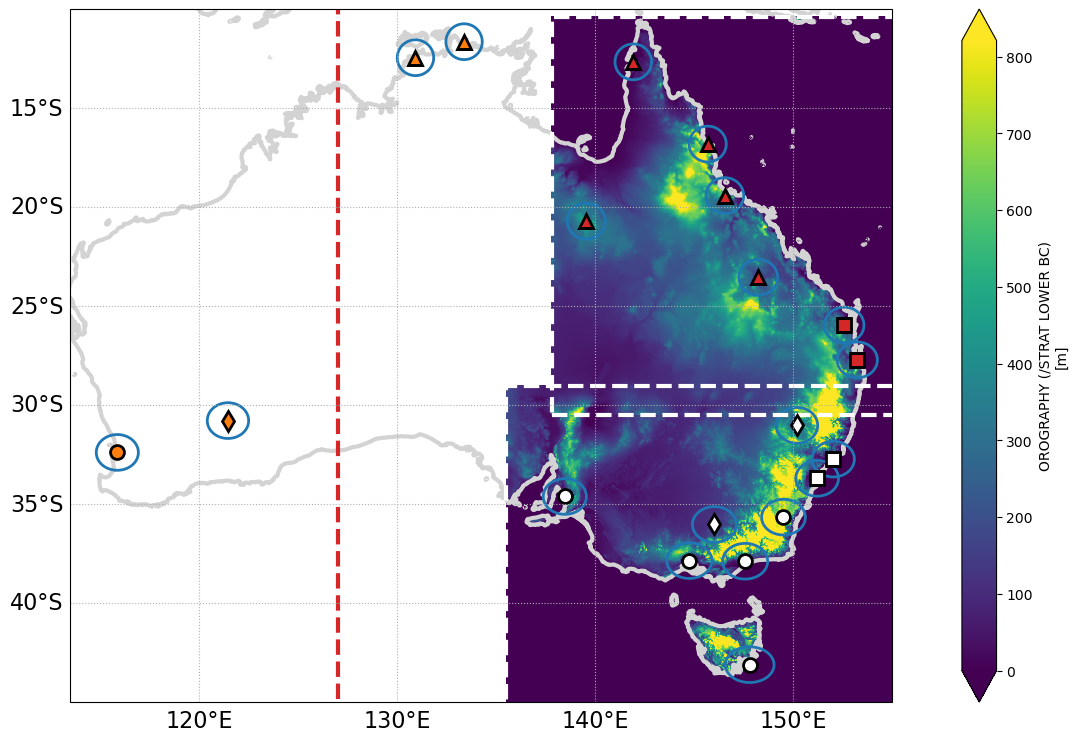

In [4]:
plt.figure(figsize=[18,9])
ax=plt.axes(projection=ccrs.PlateCarree())
f.topog.plot(ax=ax,robust=True)
t.topog.plot(ax=ax,robust=True,vmin=0,vmax=800,add_colorbar=False)
ax.coastlines(color="white",lw=2)

ax.plot([f.longitude.values.min(),f.longitude.values.max(),f.longitude.values.max(),f.longitude.values.min(),f.longitude.values.min()],
         [f.latitude.values.min(),f.latitude.values.min(),f.latitude.values.max(),f.latitude.values.max(),f.latitude.values.min()],
         ls="--",color="white",lw=3)
ax.plot([t.longitude.values.min(),t.longitude.values.max(),t.longitude.values.max(),t.longitude.values.min(),t.longitude.values.min()],
         [t.latitude.values.min(),t.latitude.values.min(),t.latitude.values.max(),t.latitude.values.max(),t.latitude.values.min()],
         ls="--",color="white",lw=3)
ax.plot([r.longitude.values.min(),r.longitude.values.max(),r.longitude.values.max(),r.longitude.values.min(),r.longitude.values.min()],
         [r.latitude.values.min(),r.latitude.values.min(),r.latitude.values.max(),r.latitude.values.max(),r.latitude.values.min()],
         ls="--",color="tab:red",lw=3)

rids = ["2","66","69","70","71","64","8","72","75","19","73","78","49","4","40","48","68","63","76","77"]
states = ["vic","qld","nsw","wa","nsw","sa","qld","qld","qld","qld","qld","qld","vic_nsw","nsw","nsw","wa","vic","nt","tas","nt"]
tropical_rids=["63","72","75","19","73","78",'77']
east_coast_rids=["4","8","66","71"]
inland_rids=["48","49","69"]
south_coast_rids=["70","2","68","64","76","40"]

ax.set_xlim([113.5,155])
ax.set_ylim([-45,-10])
ax.coastlines("10m",color="lightgray",lw=3)
g=ax.gridlines(draw_labels=True,ylabel_style={"size":16},xlabel_style={"size":16},ls=":"); g.top_labels=False; g.right_labels=False


size=10
for i in np.arange(len(rids)):
    f2=xr.open_dataset(glob.glob("/g/data/rq0/level_2/"+rids[i]+"/COLUMNMAXREFLECTIVITY/*.nc")[-1])
    lat0=f2.attrs["origin_latitude"]
    lon0=f2.attrs["origin_longitude"]    
    
    if rids[i] in ["2","4","40","49","64","68","69","71","76"]:
        mark_col = "white"
    elif rids[i] in ["8","19","66","72","73","75","78"]:
        mark_col = "tab:red"        
    else:
        mark_col = "tab:orange"        
    
    if rids[i] in tropical_rids:
        plot_radar(ax,[lon0],[lat0],ms=size,ring_color="tab:blue",color=mark_col,marker="^",mec="k",mew=2)
    elif rids[i] in east_coast_rids:
        plot_radar(ax,[lon0],[lat0],ms=size,ring_color="tab:blue",color=mark_col,marker="s",mec="k",mew=2)
    elif rids[i] in inland_rids:
        plot_radar(ax,[lon0],[lat0],ms=size,ring_color="tab:blue",color=mark_col,marker="d",mec="k",mew=2)
    elif rids[i] in south_coast_rids:
        plot_radar(ax,[lon0],[lat0],ms=size,ring_color="tab:blue",color=mark_col,marker="o",mec="k",mew=2)
    else:    
        plot_radar(ax,[lon0],[lat0],ms=size,ring_color="tab:blue",color=mark_col,marker="^",mec="k",mew=2)

In [5]:
#Radars in BARPAC-M:
#["2","4","40","49","64","68","69","71","76"]

#Radars in BARPAC-T:
#["8","19","66","72","73","75","78"]

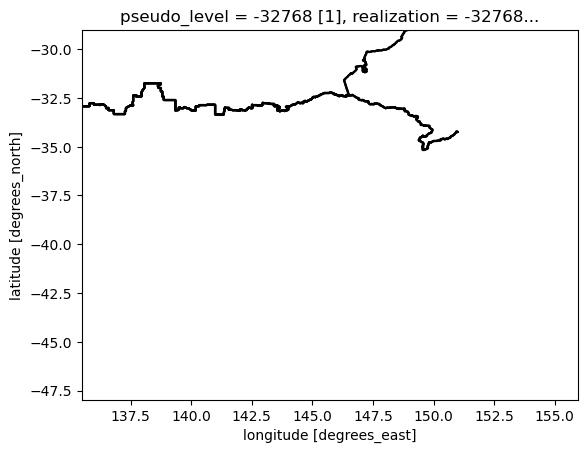

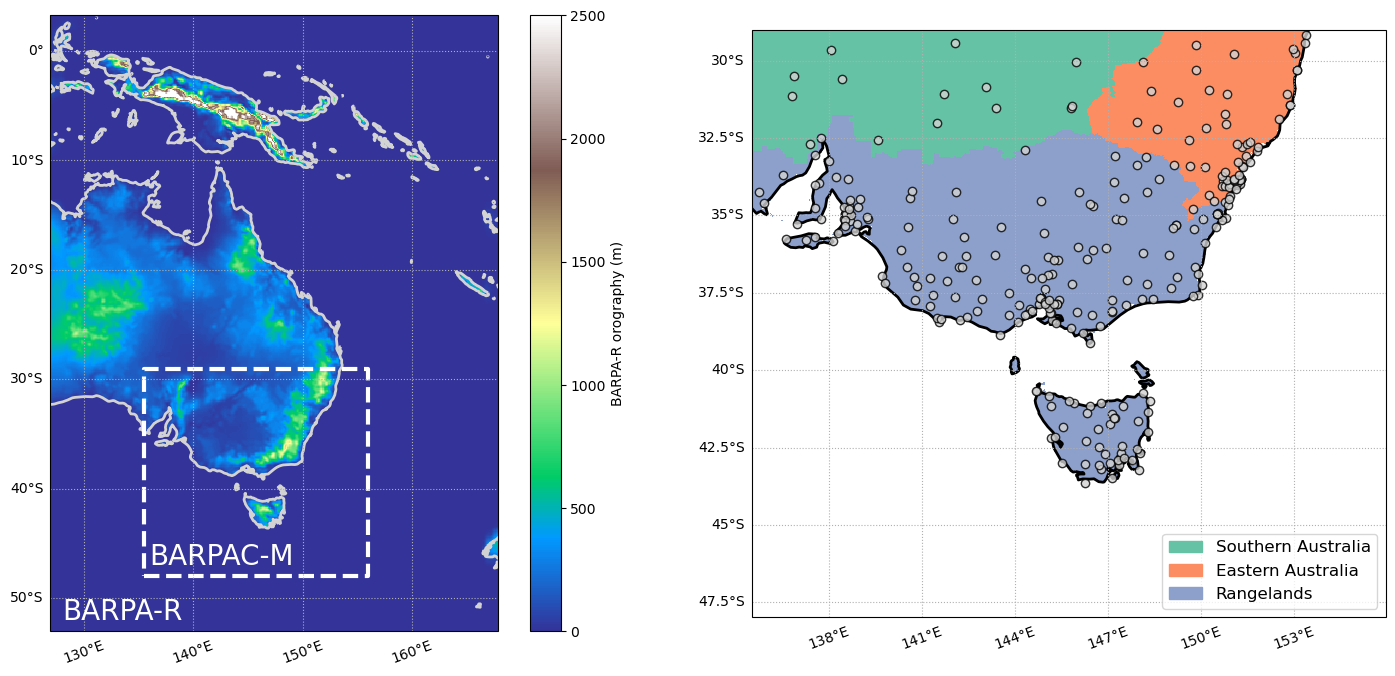

In [69]:
def return_drop_list(state):

        #Contains lists of stations to drop from each state. Generally either too high above sea level, or offshore.    

        assert state in ["qld","nsw","vic","sa","wa","vic_nsw","tas","nt"]

        if state=="qld":
                return [41175, 200840, 200601, 200736, 200783, 200701, 200831, 200732, 200704, 200001,\
                                200283, 39122, 39059, 27058, 27054, 40927, 40926, 40925, 40043, 31037]
        elif state=="vic":
                return [83084, 86376, 79103, 82139, 86381, 85291, 83024, 83085, 79101, 86344]
        elif state=="nsw":
                return [56238, 72161, 56243, 63292, 70349, 62100, 71075, 71032, 200288, 200839, 66196, 66062, 70349, 69017 ]
        elif state=="wa":
                return [9091,9193,9255,9256]
        elif state=="sa":
                return [18115]
        elif state=="vic_nsw":
                #This is only really relevant for Yarrawonga radar that's on the border
                return [83084, 86376, 79103, 82139, 86381, 85291, 83024, 83085, 79101, 86344, 56238, 72161, 56243, 63292, 70349, 62100, 71075, 71032, 200288, 200839, 66196]
        elif state=="tas":
                return [94087,200838,98017,99005]
        elif state=="nt":
                return [14056, 14274]

def barpac_stations(stn_info,domain):
    
    if domain=="m":
        f = xr.open_dataset("/g/data/tp28/BARPA/trials/BARPAC-M_km2p2/static/topog-BARPAC-M_km2p2.nc")
    elif domain=="t":
        f = xr.open_dataset("/g/data/tp28/BARPA/trials/BARPAC-T_km4p4/static/topog-BARPAC-T_km4p4.nc")
    else:
        raise ValueError("Domain must be m or t")
        
    
    lon_bnds = [f.longitude.values.min(),f.longitude.values.max()]
    lat_bnds = [f.latitude.values.min(),f.latitude.values.max()]    
    
    return stn_info.loc[(stn_info.lon >= lon_bnds[0]) & (stn_info.lon <= lon_bnds[1]) & (stn_info.lat >= lat_bnds[0]) & (stn_info.lat <= lat_bnds[1])]



stn_vic = barpac_stations(load_stn_info("vic"),"m")
stn_vic = stn_vic.loc[np.in1d(stn_vic.stn_no,return_drop_list("vic"),invert=True)]

stn_nsw = barpac_stations(load_stn_info("nsw"),"m")
stn_nsw = stn_nsw.loc[np.in1d(stn_nsw.stn_no,return_drop_list("nsw"),invert=True)]

stn_sa = barpac_stations(load_stn_info("sa"),"m")
stn_sa = stn_sa.loc[np.in1d(stn_sa.stn_no,return_drop_list("sa"),invert=True)]

stn_qld = barpac_stations(load_stn_info("qld"),"t")
stn_qld = stn_qld.loc[np.in1d(stn_qld.stn_no,return_drop_list("qld"),invert=True)] 

stn_tas = barpac_stations(load_stn_info("tas"),"m")
stn_tas = stn_tas.loc[np.in1d(stn_tas.stn_no,return_drop_list("tas"),invert=True)]

plt.figure(figsize=[18,8])
ax=plt.subplot(1,2,1,projection=ccrs.PlateCarree())

c=r.topog.plot(ax=ax,robust=True,vmin=0,vmax=2500,add_colorbar=False,cmap="terrain",extend="max")

cb=plt.colorbar(c)
cb.set_label("BARPA-R orography (m)")

#f.topog.plot(ax=ax,robust=True,cmap="Greys")

ax.coastlines(color="lightgrey",lw=2)
ax.plot([f.longitude.values.min(),f.longitude.values.max(),f.longitude.values.max(),f.longitude.values.min(),f.longitude.values.min()],
         [f.latitude.values.min(),f.latitude.values.min(),f.latitude.values.max(),f.latitude.values.max(),f.latitude.values.min()],
         ls="--",color="white",lw=3)
#ax.plot([t.longitude.values.min(),t.longitude.values.max(),t.longitude.values.max(),t.longitude.values.min(),t.longitude.values.min()],
#         [t.latitude.values.min(),t.latitude.values.min(),t.latitude.values.max(),t.latitude.values.max(),t.latitude.values.min()],
#         ls="--",color="k",lw=3)

g=ax.gridlines(draw_labels=True,ylabel_style={"size":10},xlabel_style={"size":10,"rotation":20},ls=":"); g.top_labels=False; g.right_labels=False

ax.text(136,-47,"BARPAC-M",color="white",fontdict={"size":20,"fontweight":"medium"})
ax.text(128,-52,"BARPA-R",color="white",fontdict={"size":20,"fontweight":"medium"})

plt.title("")

ax=plt.subplot(1,2,2,projection=ccrs.PlateCarree())
xr.plot.pcolormesh(f.nrm,add_colorbar=False,colors=['#66c2a5','#fc8d62','#8da0cb'],levels=[0.5,1.5,2.5,3.5])
g=ax.gridlines(draw_labels=True,ylabel_style={"size":10},xlabel_style={"size":10,"rotation":20},ls=":"); g.top_labels=False; g.right_labels=False
ax.coastlines(color="k",lw=2)

color="lightgray"
ax.plot(stn_vic.lon,stn_vic.lat,color=color,marker="o",ls="none",alpha=0.8,mec="k")
ax.plot(stn_nsw.lon,stn_nsw.lat,color=color,marker="o",ls="none",alpha=0.8,mec="k")
ax.plot(stn_sa.lon,stn_sa.lat,color=color,marker="o",ls="none",alpha=0.8,mec="k")
ax.plot(stn_tas.lon,stn_tas.lat,color=color,marker="o",ls="none",alpha=0.8,mec="k")

labels = ["Southern Australia","Eastern Australia","Rangelands"]
handles = [plt.Rectangle((0,0),1,1,color=c,label=l) for c, l in zip(['#66c2a5','#fc8d62','#8da0cb'], labels)]

plt.legend(handles,labels,loc=4,fontsize="large")
plt.title("")

plt.savefig("/g/data/eg3/ab4502/figs/barpa/map.jpeg",dpi=400,bbox_inches="tight")